In [1]:
from tdc.multi_pred import DrugSyn
import pandas as pd

from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import Chem, RDLogger

import numpy as np
from rdkit.Chem.GraphDescriptors import Ipc
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from collections import OrderedDict, Counter

from rdkit.Chem import AllChem

from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold

from rdkit import Chem
from rdkit.Chem import PandasTools, MACCSkeys
from rdkit.Chem import Draw, DataStructs
from rdkit.Chem.Draw import IPythonConsole

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [13]:
data = DrugSyn(name = "OncoPolyPharmacology")
dataset=data.get_data()
dataset

Found local copy...
Loading...


MemoryError: 

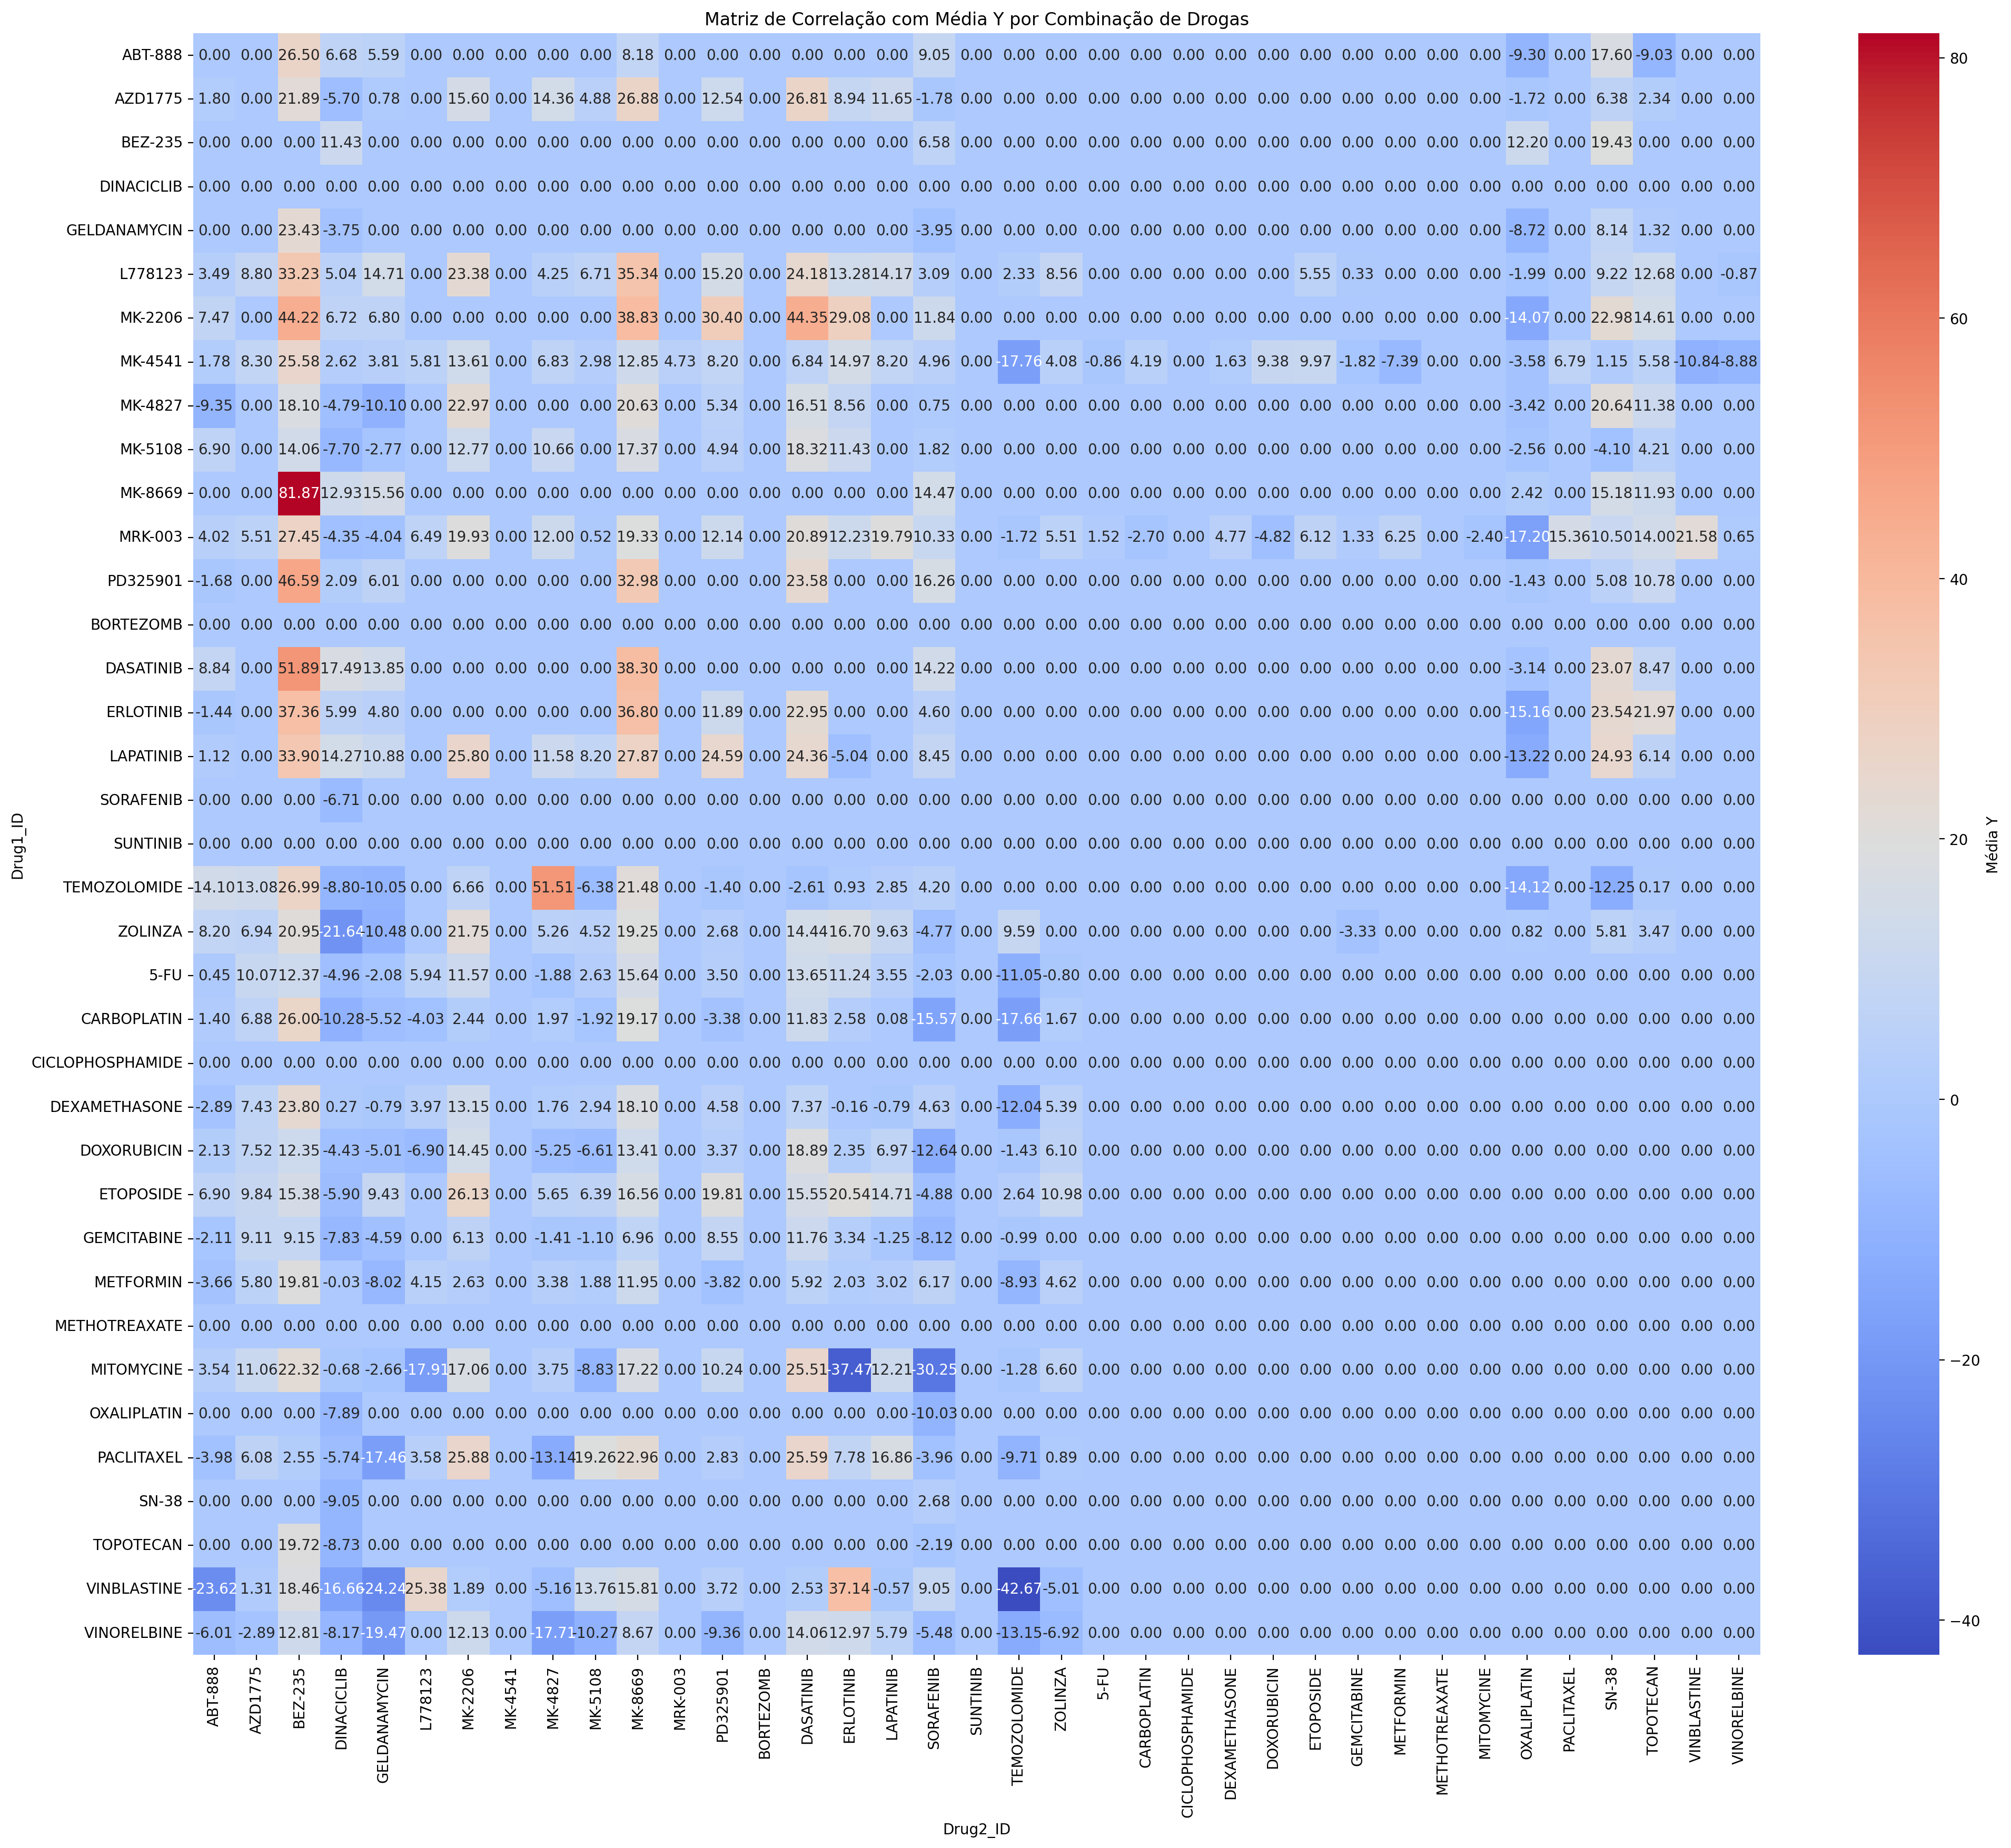

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
test=dataset
ordem_drogas = ["ABT-888","AZD1775","BEZ-235","DINACICLIB","GELDANAMYCIN","L778123","MK-2206","MK-4541", "MK-4827","MK-5108","MK-8669","MRK-003","PD325901","BORTEZOMB","DASATINIB","ERLOTINIB","LAPATINIB","SORAFENIB","SUNTINIB","TEMOZOLOMIDE","ZOLINZA","5-FU","CARBOPLATIN","CICLOPHOSPHAMIDE","DEXAMETHASONE","DOXORUBICIN","ETOPOSIDE","GEMCITABINE","METFORMIN","METHOTREAXATE","MITOMYCINE","OXALIPLATIN","PACLITAXEL","SN-38","TOPOTECAN","VINBLASTINE","VINORELBINE"]
test['Drug1_ID'] = pd.Categorical(test['Drug1_ID'], categories=ordem_drogas, ordered=True)
test['Drug2_ID'] = pd.Categorical(test['Drug2_ID'], categories=ordem_drogas, ordered=True)

# Calcular a média dos valores Y para cada combinação de drogas
media_por_combinacao = test.groupby(['Drug1_ID', 'Drug2_ID'])['Y'].mean().reset_index()

matriz_media = media_por_combinacao.pivot(index='Drug1_ID', columns='Drug2_ID', values='Y').fillna(0)
plt.figure(figsize=(24, 20), dpi=200)

sns.heatmap(matriz_media, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'Média Y'},
            xticklabels=ordem_drogas, yticklabels=ordem_drogas)

plt.xlabel('Drug2_ID')
plt.ylabel('Drug1_ID')
plt.title('Matriz de Correlação com Média Y por Combinação de Drogas')

plt.show()

In [6]:
from itertools import product

drogas_nao_combinadas = ["5-FU", "CARBOPLATIN", "CICLOPHOSPHAMIDE", "DEXAMETHASONE", "DOXORUBICIN", "ETOPOSIDE",
                     "GEMCITABINE", "METFORMIN", "METHOTREAXATE", "MITOMYCINE", "OXALIPLATIN", "PACLITAXEL",
                     "SN-38", "TOPOTECAN", "VINBLASTINE", "VINORELBINE"]

# Gerar todas as combinações de drogas a excluir
combinacoes_nao_existentes = list(product(drogas_nao_combinadas, drogas_nao_combinadas))

In [8]:
#retirar as combinações droga A-droga A porque nao faz sentido
filtered_list = [tupla for tupla in combinacoes_nao_existentes if tupla[0] != tupla[1]]

print(filtered_list)

[('5-FU', 'CARBOPLATIN'), ('5-FU', 'CICLOPHOSPHAMIDE'), ('5-FU', 'DEXAMETHASONE'), ('5-FU', 'DOXORUBICIN'), ('5-FU', 'ETOPOSIDE'), ('5-FU', 'GEMCITABINE'), ('5-FU', 'METFORMIN'), ('5-FU', 'METHOTREAXATE'), ('5-FU', 'MITOMYCINE'), ('5-FU', 'OXALIPLATIN'), ('5-FU', 'PACLITAXEL'), ('5-FU', 'SN-38'), ('5-FU', 'TOPOTECAN'), ('5-FU', 'VINBLASTINE'), ('5-FU', 'VINORELBINE'), ('CARBOPLATIN', '5-FU'), ('CARBOPLATIN', 'CICLOPHOSPHAMIDE'), ('CARBOPLATIN', 'DEXAMETHASONE'), ('CARBOPLATIN', 'DOXORUBICIN'), ('CARBOPLATIN', 'ETOPOSIDE'), ('CARBOPLATIN', 'GEMCITABINE'), ('CARBOPLATIN', 'METFORMIN'), ('CARBOPLATIN', 'METHOTREAXATE'), ('CARBOPLATIN', 'MITOMYCINE'), ('CARBOPLATIN', 'OXALIPLATIN'), ('CARBOPLATIN', 'PACLITAXEL'), ('CARBOPLATIN', 'SN-38'), ('CARBOPLATIN', 'TOPOTECAN'), ('CARBOPLATIN', 'VINBLASTINE'), ('CARBOPLATIN', 'VINORELBINE'), ('CICLOPHOSPHAMIDE', '5-FU'), ('CICLOPHOSPHAMIDE', 'CARBOPLATIN'), ('CICLOPHOSPHAMIDE', 'DEXAMETHASONE'), ('CICLOPHOSPHAMIDE', 'DOXORUBICIN'), ('CICLOPHOSPHAMIDE

In [9]:
drogas_unicas = list(OrderedDict.fromkeys(dataset['Drug1'])) #drug 1 ou drug 2 têm as mesmas drogas mas em ordem diferente
drogas_unicas

['O=c1[nH]cc(F)c(=O)[nH]1',
 'CC1(c2nc3c(C(N)=O)cccc3[nH]2)CCCN1',
 'C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-c1cccc(C(C)(C)O)n1',
 'Cn1c(=O)n(-c2ccc(C(C)(C)C#N)cc2)c2c3cc(-c4cnc5ccccc5c4)ccc3ncc21',
 'CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O',
 'N.N.O=C(O)C1(C(=O)O)CCC1.[Pt]',
 'O=P1(N(CCCl)CCCl)NCCCO1',
 'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1',
 'CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO',
 'CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCCC3CCO)nc12',
 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N)C(O)C(C)O1',
 'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1',
 'COc1cc(C2c3cc4c(cc3C(OC3OC5COC(C)OC5C(O)C3O)C3COC(=O)C23)OCO4)cc(OC)c1O',
 'COC1=C2CC(C)CC(OC)C(O)C(C)C=C(C)C(OC(N)=O)C(OC)C=CC=C(C)C(=O)NC(=CC1=O)C2=O',
 'Nc1ccn(C2OC(CO)C(O)C2(F)F)c(=O)n1',
 'N#Cc1ccc(Cn2cncc2CN2CCN(c3cccc(Cl)c3)C(=O)C2)cc1',
 'CS(=O)(=O)CCNCc1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cccc(F)c5)c(Cl)c4)c3c2)o1',
 'CN(C)C(=N)N=C(N)N',
 'CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CC

In [11]:
drogas = list(OrderedDict.fromkeys(dataset['Drug1_ID'])) #drug 1 ou drug 2 têm as mesmas drogas mas em ordem diferente
print(len(drogas))

34
